In [9]:
%matplotlib notebook
import beamsolve as bs
from beam_solver import beamsolve as bs
from beam_solver import beam_utils as bt
import catdata as cd
from beam_solver.data import DATA_PATH
import numpy as np
import pylab
import glob
import pickle
import h5py
import os

## Loading right ascension and declination values and fitsfiles for xx and yy polarizations

In [10]:
fitsfiles_xx = glob.glob('/Users/Ridhima/Documents/ucb_projects/beam_characterization/smooth/2458115.*.xx.fits')
fitsfiles_xx = sorted(fitsfiles_xx)

In [11]:
fitsfiles_yy = glob.glob('/Users/Ridhima/Documents/ucb_projects/beam_characterization/smooth/2458115.*.yy.fits')
fitsfiles_yy = sorted(fitsfiles_yy)

In [12]:
srcdict_xx = pickle.load(open('/Users/Ridhima/Documents/ucb_projects/beam_characterization/scripts/srcdict_xx.pkl'))
ras_xx = srcdict_xx['ra']
decs_xx = srcdict_xx['dec']

srcdict_yy = pickle.load(open('/Users/Ridhima/Documents/ucb_projects/beam_characterization/scripts/srcdict_yy.pkl'))
ras_yy = srcdict_yy['ra']
decs_yy = srcdict_yy['dec']

## Generating catalogs for xx and yy polarizations

In [5]:
catd_xx = cd.catData()
srcdict_xx = catd_xx.gen_catalog(fitsfiles_xx, ras_xx, decs_xx, return_data=True)

extract.py:148: Warning: WARNING: Right ascension or declination outside image field, therefore values are set to nan
  warnings.warn('WARNING: Right ascension or declination outside image field, therefore values are set to nan', Warning)


In [8]:
import h5py
srcd = cd.catData()
srcd.read_hdf5('srcd_xx.h5')

In [13]:
catd_yy = cd.catData()
srcdict_yy = catd_yy.gen_catalog(fitsfiles_yy, ras_yy, decs_yy, return_data=True)

## Writing to disk

In [14]:
%load_ext autoreload
%autoreload
catd_xx.write_hdf5('srcd_xx.h5', clobber=True)
catd_yy.write_hdf5('srcd_yy.h5', clobber=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Overwriting existing file.
Overwriting existing file.


## Calculating corrected flux values

In [10]:
beamfits = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
beam_xx = bt.get_fitsbeam(beamfits, 151e6, 'xx')
corrflux_xx = catd_xx.calc_corrflux(beam_xx, 'xx')

beam_yy = bt.get_fitsbeam(beamfits, 151e6, 'yy')
corrflux_yy = catd_yy.calc_corrflux(beam_yy, 'yy')

Casting complex values to real discards the imaginary part


## Constructing primary beam 

In [33]:
bms_xx = bs.BeamSolveBase(cat=catd_xx)
bms_xx.construct_linear_sys(mflux = corrflux_xx)
sol_xx = bms_xx.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.89 seconds


In [34]:
bms_yy = bs.BeamSolveBase(cat=catd_yy)
bms_yy.construct_linear_sys(mflux = corrflux_yy)
sol_yy = bms_yy.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.73 seconds


In [35]:
obsbeam_xx = bs.eval_linear_sol(sol_xx, 60)
obsbeam_yy = bs.eval_linear_sol(sol_yy, 60)

<IPython.core.display.Javascript object>


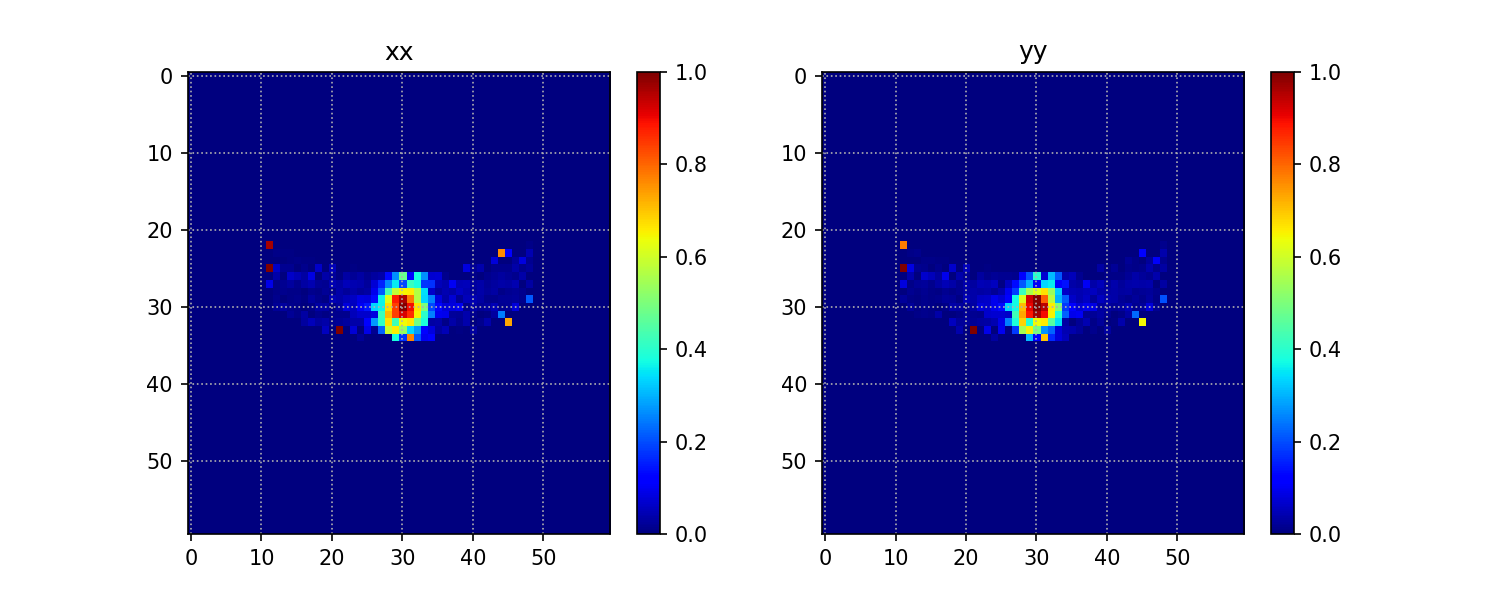

In [36]:
pylab.figure(figsize=(10,4))
pylab.subplot(121)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

pylab.subplot(122)
pylab.title('yy')
pylab.imshow(obsbeam_yy.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

Removing degenerated modes

Removing all eigen modes above 328
Removing all eigen modes above 328


<IPython.core.display.Javascript object>


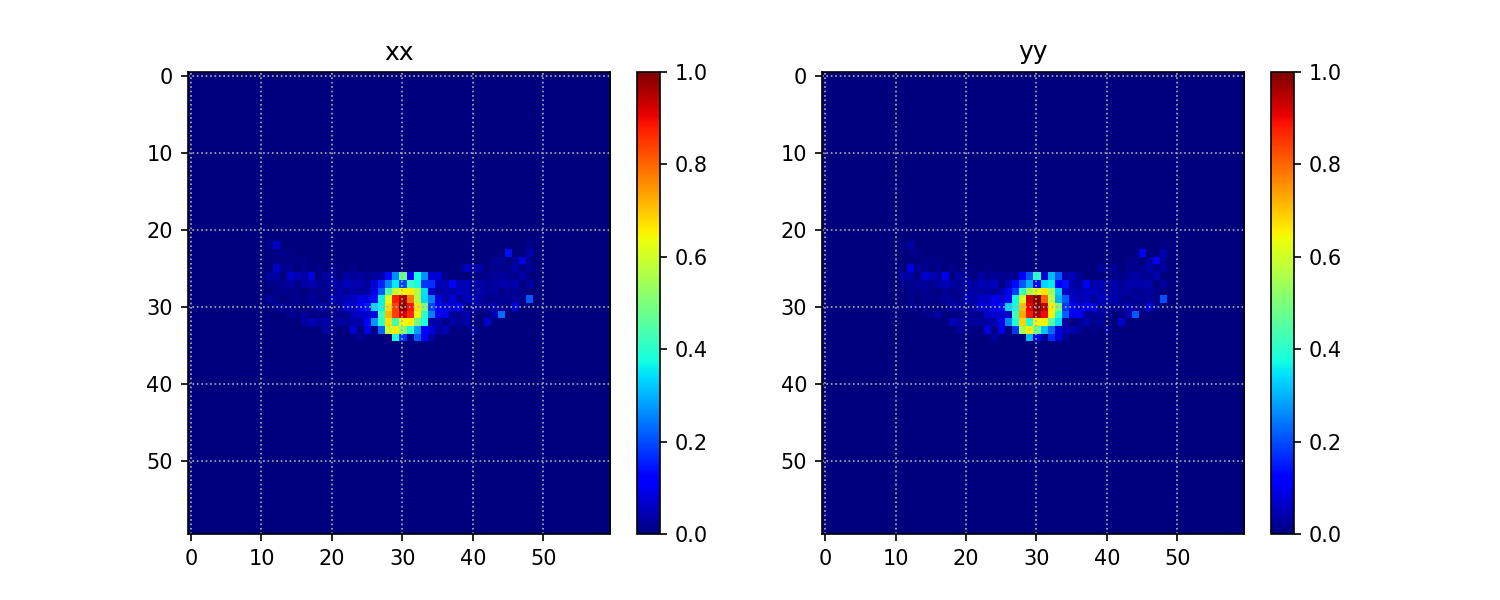

In [37]:
obsbeam_xx = bs.remove_degen(bms_xx.ls, obsbeam_xx, 60, threshold=0.0004)
obsbeam_yy = bs.remove_degen(bms_yy.ls, obsbeam_yy, 60, threshold=0.0004)

pylab.figure(figsize=(10,4))
pylab.subplot(121)
pylab.title('xx')
pylab.imshow(obsbeam_xx.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

pylab.subplot(122)
pylab.title('yy')
pylab.imshow(obsbeam_yy.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

## Constructing beam using cross polarizations 

In [15]:
catd = cd.catData()
srcdict = catd.gen_polcatalog(fitsfiles_xx, fitsfiles_yy, ras_xx, decs_xx, return_data=True)

In [73]:
beam_xx = bt.get_fitsbeam(beamfits, 151e6, 'xx')
corrflux_xx = catd.calc_corrflux(beam_xx, 'xx')

beam_yy = bt.get_fitsbeam(beamfits, 151e6, 'yy')
corrflux_yy = catd.calc_corrflux(beam_yy, 'yy')

In [16]:
catd.write_hdf5('polsrcd.h5', clobber=True)

Overwriting existing file.


In [104]:
bms = bs.BeamSolveCross(cat=catd)
bms.construct_linear_sys(mflux_xx = corrflux_xx, mflux_yy = corrflux_yy, theta_xx=[0], theta_yy=[np.pi/2], flip=[1])
sol = bms.solve(solver='Linear')

Solving 0/1
Time Elapsed: 1.73 seconds


<IPython.core.display.Javascript object>


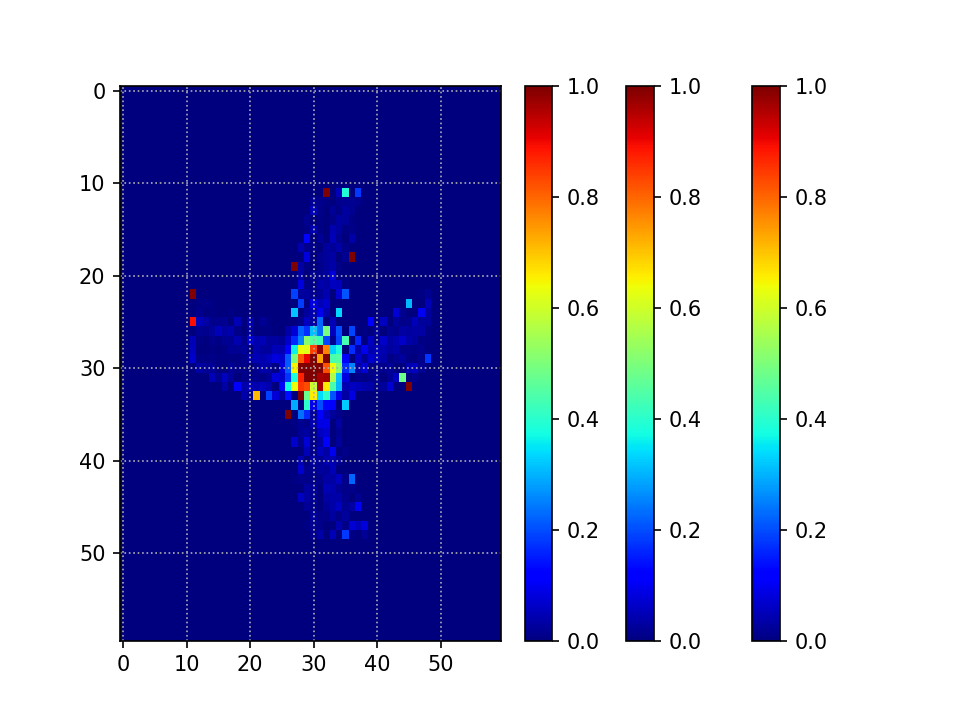

In [105]:
obsbeam = bs.eval_linear_sol(sol, 60)
pylab.subplot(111)
pylab.imshow(obsbeam.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

In [107]:
bms = bs.BeamSolveCross(cat=catd)
bms.construct_nonlinear_sys(mflux_xx = corrflux_xx, mflux_yy = corrflux_yy, bvals=np.zeros((60, 60)), theta_xx=[0], theta_yy=[np.pi/2], flip=[1], constrain=True)
sol = bms.solve(solver='LinProduct')

Beginning iteration 1/50
Solving 0/1
Beginning iteration 2/50
Solving 0/1
Beginning iteration 3/50
Solving 0/1
Beginning iteration 4/50
Solving 0/1
Beginning iteration 5/50
Solving 0/1
Beginning iteration 6/50
Solving 0/1
Beginning iteration 7/50
Solving 0/1
Beginning iteration 8/50
Solving 0/1
Beginning iteration 9/50
Solving 0/1
Beginning iteration 10/50
Solving 0/1
Beginning iteration 11/50
Solving 0/1
Beginning iteration 12/50
Solving 0/1
Beginning iteration 13/50
Solving 0/1
Beginning iteration 14/50
Solving 0/1
Beginning iteration 15/50
Solving 0/1
Beginning iteration 16/50
Solving 0/1
Beginning iteration 17/50
Solving 0/1
Beginning iteration 18/50
Solving 0/1
Beginning iteration 19/50
Solving 0/1
Beginning iteration 20/50
Solving 0/1
Beginning iteration 21/50
Solving 0/1
Beginning iteration 22/50
Solving 0/1
Beginning iteration 23/50
Solving 0/1
Beginning iteration 24/50
Solving 0/1
Beginning iteration 25/50
Solving 0/1
Beginning iteration 26/50
Solving 0/1
Beginning iteration 2

<IPython.core.display.Javascript object>


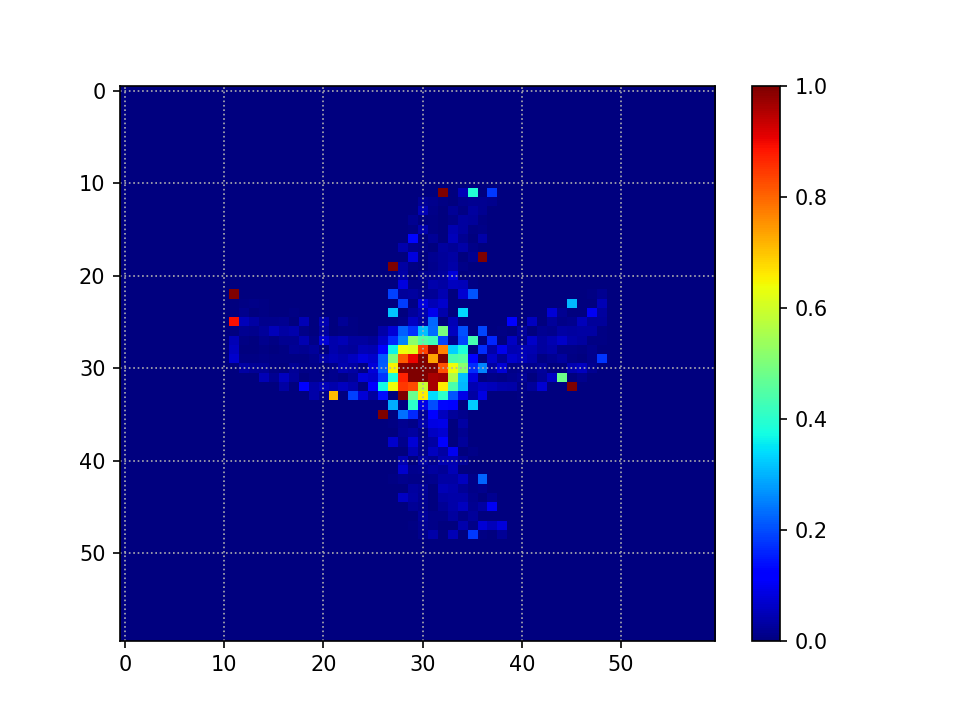

In [110]:
fluxvals, obsbeam_cross = bs.eval_nonlinear_sol(sol, catd.Nsrcs, 60)
pylab.subplot(111)
pylab.imshow(obsbeam_cross.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.colorbar()
pylab.grid(ls='dotted')

In [97]:
import aipy

def rotate_mat(theta):
    """
    Rotate coordinates or pixels by theta degrees

    Parameters
    ----------
    theta : float
            Angle by which the coordinates or pixels will be rotated.
    """

    return np.array([[np.cos(theta), -1*np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def get_weights(azalts, bm_pix, theta=0, flip=1):
    """
    Returns the four closest pixels to the azimuth-altitude values on the 2D
    grid.

    Parameters
    ----------
    azalts : ndarray
        2D array consisting of the azimuth and alitutes values in degrees.
    """

    # selecting the four closest pixels
    tx, ty, tz = aipy.coord.azalt2top([azalts[0, :] * np.pi/180., azalts[1, :] * np.pi/180.])
    print tx, ty
    tx, ty = np.dot(rotate_mat(theta), np.array([tx, ty]))
    print 'rot:', tx, ty
    tx = flip * tx
    print tx, ty
    tx_px = tx * 0.5 * bm_pix + 0.5 * bm_pix
    ty_px = ty * 0.5 * bm_pix + 0.5 * bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0 + 1, 0, bm_pix -1)
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0 + 1, 0, bm_pix -1)

In [115]:
print rotate_mat(0)
print rotate_mat(np.pi)
print rotate_mat(2*np.pi)

[[ 1. -0.]
 [ 0.  1.]]
[[-1.0000000e+00 -1.2246468e-16]
 [ 1.2246468e-16 -1.0000000e+00]]
[[ 1.0000000e+00  2.4492936e-16]
 [-2.4492936e-16  1.0000000e+00]]


In [100]:
for th in [0, np.pi/2]:
    get_weights(catd.azalt_array[:, 0, 0:1], 60, theta=th, flip=1)

[0.08515481] [-0.0035428]
rot: [0.08515481] [-0.0035428]
[0.08515481] [-0.0035428]
[0.08515481] [-0.0035428]
rot: [0.0035428] [0.08515481]
[0.0035428] [0.08515481]
